<a href="https://colab.research.google.com/github/ljw-0108/medical-data-analysis/blob/main/11_tf_binding_prediction_RNA_inferience_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepChem 설치
Colab 노트북에 DeepChem 설치

tensorflow 기반 모델을 사용할 것이므로 pip install 명령에 [tensorflow]를 추가하여 필요한 종속성도 설치

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# DeepChem 설치시 Keras 종속성 버전 일치를 위해 아래 환경 변수 설정 후 import 진행
import os
os.environ["TF_USE_LEGACY_KERAS"] = '1'

In [3]:
!pip install deepchem[tensorflow]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 49.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [4]:
!pip install tf_keras

In [5]:
import deepchem as dc
dc.__version__

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


'2.8.0'

### warning 메시지 생략

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

# 전사인자 결합 예측 모델

- JUND 전사 인자의 결합 예측을 위한 CNN 모델 생성
- 2차원 이미지가 아닌 1차원 데이터 사용하는 CNN 모델

### 라이브러리 불러오기

In [7]:
import deepchem as dc
import tensorflow as tf
import tensorflow.keras.layers as layers

### 데이터 불러오기 및 확인

In [8]:
train = dc.data.DiskDataset('/content/drive/MyDrive/md/data/train_dataset')
valid = dc.data.DiskDataset('/content/drive/MyDrive/md/data/valid_dataset')

In [9]:
train.X.shape #AGTC로 이루어져 있어 4로 나타남

(276216, 101, 4)

In [10]:
train.y.shape

(276216, 1)

In [11]:
train #디스크 데이터 셋이라는 객체 데이터 얻음

<DiskDataset X.shape: (np.int64(276216), np.int64(101), np.int64(4)), y.shape: (np.int64(276216), np.int64(1)), w.shape: (np.int64(276216), np.int64(1)), task_names: [0]>

### 모델 생성

In [12]:
features = tf.keras.Input(shape=(101, 4))
prev = features

for i in range(3):
    prev = layers.Conv1D(filters=15, kernel_size=10, activation=tf.nn.relu, padding='same')(prev)
    prev = layers.Dropout(rate=0.5)(prev) #3번 반복하여 모델링

logits = layers.Dense(units=1)(layers.Flatten()(prev))
output = layers.Activation(tf.math.sigmoid)(logits)

In [13]:
keras_model = tf.keras.Model(inputs=features, outputs=[output, logits]) #케라스 모델 사용

model = dc.models.KerasModel(
    keras_model,
    loss=dc.models.losses.SigmoidCrossEntropy(), #시그모이드크로스엔트로피 사용
    output_types=['prediction', 'loss'],
    batch_size=1000,
    model_dir='tf')

### 모델 학습 및 평가

In [14]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score) #회귀 모델
for i in range(20):
    model.fit(train, nb_epoch=10)
    print(model.evaluate(train, [metric])) #train 값
    print(model.evaluate(valid, [metric])) #valid 값

{'roc_auc_score': np.float64(0.6036786927390108)}
{'roc_auc_score': np.float64(0.5324917633305748)}
{'roc_auc_score': np.float64(0.6886581407845425)}
{'roc_auc_score': np.float64(0.6098466300078931)}
{'roc_auc_score': np.float64(0.7690636347023163)}
{'roc_auc_score': np.float64(0.7309302027680946)}
{'roc_auc_score': np.float64(0.7965223124939986)}
{'roc_auc_score': np.float64(0.7307209740327267)}
{'roc_auc_score': np.float64(0.8161325423261117)}
{'roc_auc_score': np.float64(0.7411485437361269)}
{'roc_auc_score': np.float64(0.8265241064834811)}
{'roc_auc_score': np.float64(0.7221610733548676)}
{'roc_auc_score': np.float64(0.831940312416951)}
{'roc_auc_score': np.float64(0.7322990796525478)}
{'roc_auc_score': np.float64(0.8490557932316571)}
{'roc_auc_score': np.float64(0.7381981247208458)}
{'roc_auc_score': np.float64(0.8479340758840899)}
{'roc_auc_score': np.float64(0.7424380820403751)}
{'roc_auc_score': np.float64(0.8510478964842201)}
{'roc_auc_score': np.float64(0.7258880442487148)}
{

# 모델 수정
- Dense층 학습 시 전사 인자 조절에 관여하는 염색질 접근성 feature 추가
- feature 레이어가 2개라 fit함수 사용 불가능
- 배치별 반복 학습 수행
- iterbatches() 함수를 통해 모델에 필요한 입력 데이터 배치별 처리

In [15]:
import numpy as np

In [16]:
span_accessibility = {}
for line in open('/content/drive/MyDrive/md/data/accessibility.txt'):
    fields = line.split()
    span_accessibility[fields[0]] = float(fields[1])

In [17]:
span_accessibility

{'chr22:20208963-20209064': 0.003902,
 'chr22:29673572-29673673': 0.004378,
 'chr22:28193720-28193821': 0.001946,
 'chr22:43864274-43864375': 0.003869,
 'chr22:18261550-18261651': 0.003066,
 'chr22:49798024-49798125': 0.003794,
 'chr22:43088594-43088695': 0.005292,
 'chr22:35147671-35147772': 0.002015,
 'chr22:49486843-49486944': 0.001046,
 'chr22:21014236-21014337': 0.003394,
 'chr22:46113241-46113342': 0.004074,
 'chr22:18183679-18183780': 0.005725,
 'chr22:50791864-50791965': 0.005023,
 'chr22:18811798-18811899': 0.005777,
 'chr22:36467842-36467943': 0.003452,
 'chr22:33428651-33428752': 0.006423,
 'chr22:50113043-50113144': 0.002428,
 'chr22:33643781-33643882': 0.004774,
 'chr22:33543993-33544094': 0.005169,
 'chr22:50467250-50467351': 0.006465,
 'chr22:37420272-37420373': 0.002894,
 'chr22:50296661-50296762': 0.003144,
 'chr22:19833041-19833142': 0.002302,
 'chr22:33546316-33546417': 0.003757,
 'chr22:24708412-24708513': 0.003336,
 'chr22:46228987-46229088': 0.005614,
 'chr22:3004

In [18]:
features = tf.keras.Input(shape=(101, 4))
accessibility = tf.keras.Input(shape=(1,))

prev = features
for i in range(3):
    prev = layers.Conv1D(filters=15, kernel_size=10, activation=tf.nn.relu, padding='same')(prev)
    prev = layers.Dropout(rate=0.5)(prev)

prev = layers.Concatenate()([layers.Flatten()(prev), accessibility])

logits = layers.Dense(units=1)(prev)
output = layers.Activation(tf.math.sigmoid)(logits)
keras_model = tf.keras.Model(inputs=[features, accessibility], outputs=[output, logits])

model = dc.models.KerasModel(
    keras_model,
    loss=dc.models.losses.SigmoidCrossEntropy(),
    output_types=['prediction', 'loss'],
    batch_size=1000,
    model_dir='chromatin')

In [19]:
def generate_batches(dataset, epochs):
    for epoch in range(epochs):
        for X, y, w, ids in dataset.iterbatches(batch_size=1000, pad_batches=True):
            yield ([X, np.array([span_accessibility[id] for id in ids])], [y], [w])

### 성능 평가

In [20]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
for i in range(20):
    model.fit_generator(generate_batches(train, epochs=10))
    print(model.evaluate_generator(generate_batches(train, 1), [metric]))
    print(model.evaluate_generator(generate_batches(valid, 1), [metric]))

{'roc_auc_score': np.float64(0.665776805973221)}
{'roc_auc_score': np.float64(0.6288426942234158)}
{'roc_auc_score': np.float64(0.6900647939612985)}
{'roc_auc_score': np.float64(0.6224527856648068)}
{'roc_auc_score': np.float64(0.7499154028681672)}
{'roc_auc_score': np.float64(0.6618575470816106)}
{'roc_auc_score': np.float64(0.8121116803648373)}
{'roc_auc_score': np.float64(0.7027505782526919)}
{'roc_auc_score': np.float64(0.8625509920521406)}
{'roc_auc_score': np.float64(0.7901498925184798)}
{'roc_auc_score': np.float64(0.874980172844191)}
{'roc_auc_score': np.float64(0.8090977245343953)}
{'roc_auc_score': np.float64(0.8950989491734355)}
{'roc_auc_score': np.float64(0.791647807087142)}
{'roc_auc_score': np.float64(0.8964479500963676)}
{'roc_auc_score': np.float64(0.8000387829076485)}
{'roc_auc_score': np.float64(0.8993362758054047)}
{'roc_auc_score': np.float64(0.8060894142180443)}
{'roc_auc_score': np.float64(0.9084284896136979)}
{'roc_auc_score': np.float64(0.8205813955055837)}
{'r

# RNA 간섭 예측 모델
- RNA 서열을 입력 데이터로 사용해 RNA 간섭의 효과 예측하는 CNN 모델

In [21]:
import matplotlib.pyplot as plt

### 데이터 불러오기 및 확인

In [22]:
train = dc.data.DiskDataset('/content/drive/MyDrive/md/data/train_siRNA')
valid = dc.data.DiskDataset('/content/drive/MyDrive/md/data/valid_siRNA')

In [23]:
train.X.shape

(2187, 21, 4)

In [24]:
train.y.shape

(2187, 1)

In [25]:
train.X

array([[[0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        ...,
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 0, 0, 1]],

       [[0, 1, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        ...,
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0]],

       [[0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        ...,
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 0, 0, 1]],

       ...,

       [[1, 0, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        ...,
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]],

       [[0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        ...,
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0]],

       [[0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        ...,
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]]], dtype=int8)

### 모델 생성

In [26]:
features = tf.keras.Input(shape=(21, 4))
prev = features
for i in range(2):
    prev = layers.Conv1D(filters=10, kernel_size=10, activation=tf.nn.relu, padding='same')(prev)
    prev = layers.Dropout(rate=0.3)(prev)
output = layers.Dense(units=1, activation=tf.math.sigmoid)(layers.Flatten()(prev))
keras_model = tf.keras.Model(inputs=features, outputs=output)
model = dc.models.KerasModel(
    keras_model,
    loss=dc.models.losses.L2Loss(),
    batch_size=1000,
    model_dir='rnai')

### 모델 학습 및 평가

In [27]:
train_scores = []
valid_scores = []

In [28]:
metric = dc.metrics.Metric(dc.metrics.pearsonr, mode='regression')

for i in range(20):
    model.fit(train, nb_epoch=10)
    train_score = model.evaluate(train, [metric])['pearsonr']
    valid_score = model.evaluate(valid, [metric])['pearsonr']

    train_scores.append(train_score)
    valid_scores.append(valid_score)

    print(train_score)
    print(valid_score)

0.11288730117340232
0.18822670969944727
0.34201227634402226
0.3439153261405077
0.43791747170024664
0.38448950255561776
0.5018562149623897
0.4216387024500486
0.5562832679458365
0.47503758311988203
0.5970309046101568
0.516312219239222
0.6270537016198336
0.5509550588123349
0.6486909553216789
0.5737978545656595
0.663013041591914
0.5889724176344617
0.673196903227359
0.5937414235336733
0.6842576140350949
0.6030050770570066
0.6916520009041862
0.6040454433319111
0.6987026008522278
0.6068419039152264
0.7039291900308084
0.6093313168744776
0.7102278212513123
0.6096975483438729
0.7146789001342622
0.6132448643216487
0.7194893749919483
0.6154735517480392
0.723986687794012
0.6171005454952885
0.7281954335622781
0.6181659875808119
0.7317444158377029
0.6161075888866466


### 모델 성능 시각화

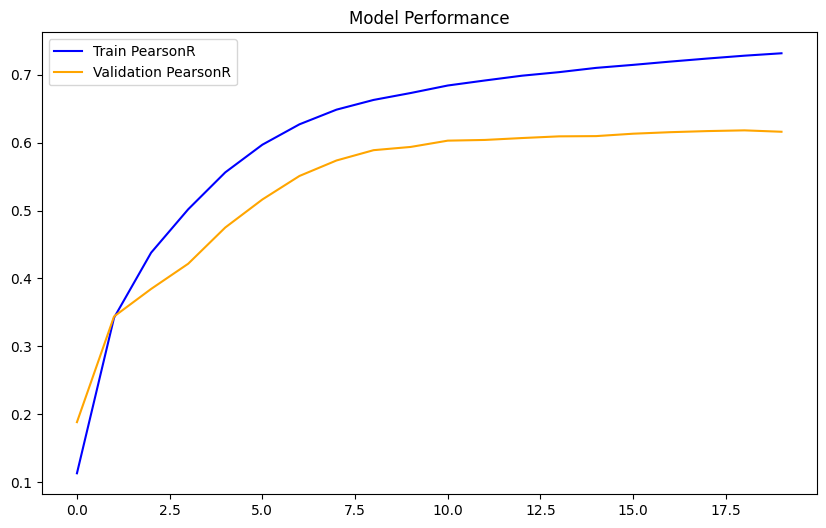

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(train_scores, label='Train PearsonR', color='blue')
plt.plot(valid_scores, label='Validation PearsonR', color='orange')

plt.title('Model Performance')
plt.legend()
plt.show()